<a href="https://colab.research.google.com/github/xssChauhan/Blog-Posts/blob/master/pytorch_lightning/PyTorch_Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch Code for Training a CNN

- Load Dataset
- Load Model
- Training Loop
- Validation Loop
- Logging

In [1]:
import torch
import torchvision

from torchvision import transforms
from torch.utils.data import DataLoader

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
)
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
)

# Define a dataset
train_dataset = torchvision.datasets.CIFAR10(root="datasets/", train=True, download=True, transform=train_transform)
val_dataset = torchvision.datasets.CIFAR10(root="datasets/", train=False, download=True, transform=val_transform)

# Define the data loaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Define the modela
def create_model():
  model = torchvision.models.resnet18(pretrained=True)
  model.fc = torch.nn.Linear(in_features=512, out_features=10)

  return model

model = create_model()

# Define the optimizer and loss function
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9,
            weight_decay=5e-4,)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)

100%|██████████| 170498071/170498071 [00:11<00:00, 15306960.43it/s]


Extracting datasets/cifar-10-python.tar.gz to datasets/
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 310MB/s]


In [ ]:
def train(model, train_dataloader):
  model.train()
  train_losses = []
  total_correct = 0
  total_samples = 0
  for batch_idx, data in enumerate(train_dataloader):
    batch, target = data
    batch = batch.to(device)
    target = target.to(device)

    preds = model(batch)
    _, predicted = torch.max(preds, 1)

        # Update the running total of correct predictions and samples
    total_correct += (predicted == target).sum().item()
    total_samples += target.size(0)

    loss = criterion(preds, target)
    optimizer.step()

    train_losses.append(loss.cpu().detach())

    if batch_idx % 200 == 0:
      print(f"Training Loss: {loss.item()}")
  print(f"Avg Epoch loss {torch.hstack(train_losses).sum()/(len(train_dataset)/64)}")
  print(f"Avg Epoch accuracy {total_correct / total_samples}")

epochs=2
for _ in range(epochs):
  train(model, train_dataloader)

def validate(model, val_dataloader):
  model.eval()
  losses = []
  total_correct = 0
  total_samples = 0
  for batch_idx, data in enumerate(val_dataloader):
    batch, target = data
    batch = batch.to(device)
    target = target.to(device)

    preds = model(batch)
    _, predicted = torch.max(preds, 1)

        # Update the running total of correct predictions and samples
    total_correct += (predicted == target).sum().item()
    total_samples += target.size(0)

    losses.append(loss.cpu().detach())

  print(f"Avg Validation Epoch loss {torch.hstack(losses).sum()/(len(val_dataset)/64)}")
  print(f"Avg Validation Epoch accuracy {total_correct / total_samples}")


## Now, what if we want to add

### Experimentation
- Does my pipeline actually work?
- LR scheduler
- Model Checkpointing
- Other metrics: Precision, Recall, F1-Score
- Play around with different data transforms?
- Hyperparameter Tuning
- ...

Considerable effort in code refactoring and organization!

## Tracking and Reproducibility
- Experiment tracking
- Integrating with Tensorboard, MLFlow, etc
- Configuration sharing
- Standardize CLI interface
- As you add more `experimentational features`, maintaining backward compatibility

## Production
- Write separate interface for production inference
- Model Quantization, Pruning?

## Collaboration
- Can this be used by my team?
- Can this be used by future me?

## PyTorch Lightning Refactoring and benefits

## Reduce Boilerplate
  ```python
  model.train()
  train_losses = []
  total_correct = 0
  total_samples = 0
  for batch_idx, data in enumerate(train_dataloader):
    batch, target = data
    batch = batch.to(device)
    target = target.to(device)
    
    preds = model(batch)
    _, predicted = torch.max(preds, 1)

        # Update the running total of correct predictions and samples
    total_correct += (predicted == target).sum().item()
    total_samples += target.size(0)

    loss = criterion(preds, target)
    optimizer.step()

    train_losses.append(loss.cpu().detach())

    if batch_idx % 200 == 0:
      print(f"Training Loss: {loss.item()}")
  print(f"Avg Epoch loss {torch.hstack(train_losses).sum()/(len(train_dataset)/64)}")
  print(f"Avg Epoch accuracy {total_correct / total_samples}")
  ```
  - We should not have to worry about
    - Looping and batches
    - Tracking metrics
    - Writing code for metrics
    - Logging metrics, artifacts, visualizations

  
## Organize Code into Logical Units and Standardize the organization
- Better mental model -> Better organization and accumulation of code
- Plug and play different logical components on the fly


# How?

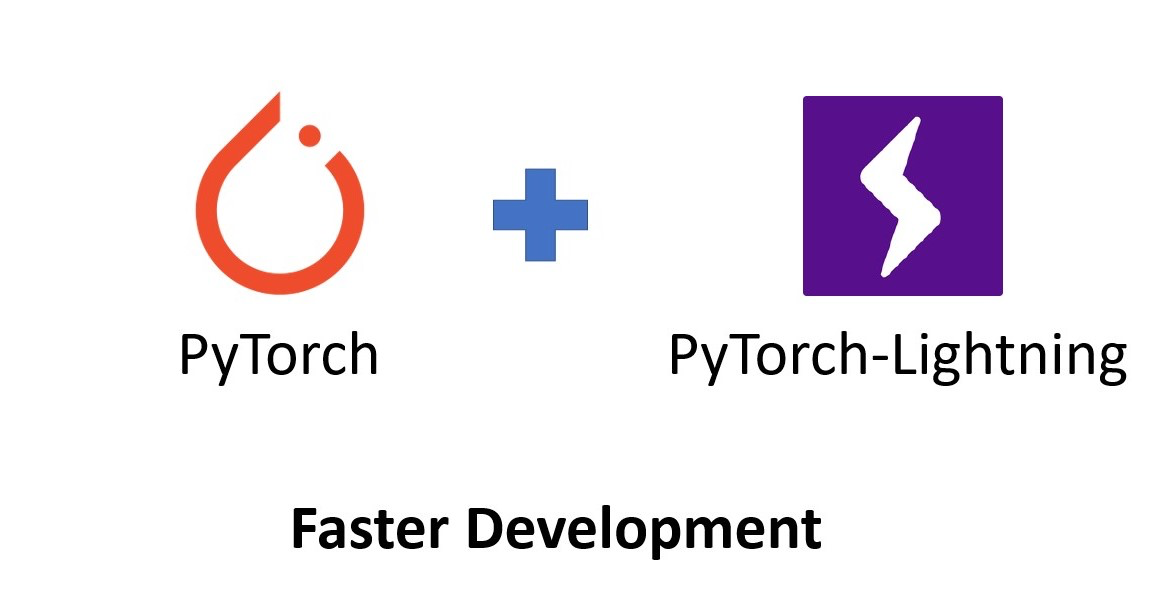

- Logical Separation between
  - where data comes from : `LightningModule`
  - what a model does to data: `LightningDataModule`
  - overall traning: `Trainer`
  

## LightningModule

- Remove boilerplate associated with training
- Standardize the logging interactions

In [3]:
! pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 43.6 MB/s eta 0:00:00


### LightningModule
  - A class that the user defines by inheriting `pytorch_lightning.LightningModule`
  - Breaks down logical steps into `hooks`

In [4]:
from pytorch_lightning import LightningModule

import torchmetrics

class Resnet18Lightning(LightningModule):

  def __init__(self, lr=5e-3):
    super().__init__()
    self.save_hyperparameters()
    self.model = create_model()

  def forward(self, batch):
    # generate inference from the model
    return

  def training_step(self, batch, batch_idx):
    # only define what happens to a batch in training
    # internally moves data to appropriate device
    # no need to keep track of the loops, epochs
    return

  def on_train_epoch_end(self):
    # do something after the training_step has been done for all training samples.
    return

  def validation_step(self, batch, batch_idx):
    # only define what happens to a batch in training
    # internally moves data to appropriate device
    return

  def on_validation_epoch_end(self):
    # do something after the validation_step has been done for all the val samples
    return

  def test_step(self, batch, batch_idx):
    # logic for inference on a batch at testing
    return

  def predict_step(self, batch, batch_idx):
    # during inference
    return

  def configure_optimizer(self):
    # configure the optimizer and schedulers
    return

Let's quickly fill in the `hooks`.


In [5]:

class Resnet18Lightning(LightningModule):

  def __init__(self, lr=5e-3):
    super().__init__()
    self.save_hyperparameters()
    self.model = create_model()

    self.train_accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
    self.val_accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)

  def forward(self, data):
    # generate inference from the model
    preds = model(data)
    _, predicted = torch.max(preds, axis=1)

    return preds, predicted

  def training_step(self, batch, batch_idx):
    input, labels = batch
    preds, predicted = self(input)

    loss = torch.nn.functional.cross_entropy(preds, labels)
    self.train_accuracy(predicted, labels)
    # log the loss for step, epoch, and show on the progress bar
    self.log("training_loss", loss, on_epoch=True, on_step=True, prog_bar=True, logger=True)
    self.log("training_acc", self.train_accuracy, prog_bar=True, logger=True, on_step=True, on_epoch=True)
    # the returned loss is used to perform backpropagation
    return loss

  def validation_step(self, batch, batch_idx):
    # only define what happens to a batch in training
    input, labels = batch
    preds, predicted = self(input)

    loss = torch.nn.functional.cross_entropy(preds, labels)
    self.val_accuracy(predicted, labels)

    self.log("validation_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    self.log("validation_acc", self.val_accuracy, prog_bar=True, logger=True, on_step=True, on_epoch=True)

    # no need to return anything
    return

  def configure_optimizers(self):
    # configure the optimizer and schedulers
    optimizer = torch.optim.SGD(
        self.parameters(),
        self.hparams.lr,  # <--- This was passed as an argument to __init__
    )

    return optimizer


Let's train using this module quickly!

In [7]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

module = Resnet18Lightning()
trainer = Trainer(
    max_epochs=1,
    logger = CSVLogger("logs/"),
    accelerator="cuda"
)

# trainer.fit(module, train_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [12]:
trainer.validate(module, val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ validation_acc_step_epoch │    0.08489999920129776    │
│   validation_loss_epoch   │     2.480074167251587     │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss_epoch': 2.480074167251587,
  'validation_acc_step_epoch': 0.08489999920129776}]

But, how about aggregating results over an epoch?

In [8]:
# We can inherit and distibute functionality

class Resnet18LightningEpoch(Resnet18Lightning):

  def __init__(self,*args, **kwargs):
    super().__init__(*args, **kwargs)

  def on_train_epoch_end(self):
    self.log("training_acc_epoch", self.train_accuracy)

  def on_validation_epoch_end(self):
    self.log("validation_acc_epoch", self.val_accuracy)


module = Resnet18LightningEpoch()

trainer = Trainer(
    max_epochs=1,
    logger = CSVLogger("logs/"),
    accelerator="cuda"
)

# trainer.fit(module, train_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Learning Rate Scheduling

In [ ]:
from torch.optim.lr_scheduler import StepLR

class Resnet18LightningWithLRScheduling(Resnet18LightningEpoch):

  def configure_optimizers(self):

    optimizer = torch.optim.SGD(
        self.parameters(),
        self.hparams.lr,  # <--- This was passed as an argument to __init__
    )
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

    return {
        "optimizer": optimizer,
        "lr_scheduler": scheduler
    }

## Model Checkpointing and Callbacks

Checkpointing / adding callbacks is rather twisted in vanilla `PyTorch`.

`Lightning` provides standard API for it.

In [23]:
from pytorch_lightning.callbacks import ModelCheckpoint


# Save the best checkpoint based on validation loss

val_loss_checkpointer = ModelCheckpoint(
    monitor="validation_loss_epoch",
    filename="{epoch}_{validation_loss_epoch:.2f}",
    mode="min"
)

trainer = Trainer(
    max_epochs=2,
    callbacks=[val_loss_checkpointer],
    logger=CSVLogger("logs/"),
    accelerator="cuda"
)
trainer.fit(module, train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params
------------------------------------------------------
0 | model          | ResNet             | 11.2 M
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


A few more callback options are:
- `LearningRateFinder`: Find the best learning rate for the model
- `EarlyStopping`
- `ModelPruning`
- .....

## Profiling

`Lightning` comes with built in options of Profilers, so you know where is your code spending time.

In [25]:
from pytorch_lightning.profilers import SimpleProfiler

trainer = Trainer(
    max_epochs=2,
    callbacks=[val_loss_checkpointer],
    profiler=SimpleProfiler(),
    logger=CSVLogger("logs/"),
    accelerator="cuda"
)
trainer.fit(module, train_dataloader, val_dataloaders=val_dataloader)

trainer.validate(module, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory logs/lightning_logs/version_8/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params
------------------------------------------------------
0 | model          | ResNet             | 11.2 M
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
-----------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO:pytorch_lightning.profilers.profiler:FIT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                            	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total           

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   validation_acc_epoch    │    0.08489999920129776    │
│ validation_acc_step_epoch │    0.08489999920129776    │
│   validation_loss_epoch   │     2.480074167251587     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.profilers.profiler:VALIDATE Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                            	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

[{'validation_loss_epoch': 2.480074167251587,
  'validation_acc_step_epoch': 0.08489999920129776,
  'validation_acc_epoch': 0.08489999920129776}]

# LightningDataModule
Datamodules are for you if you ever asked the questions:

- what splits did you use?
- what transforms did you use?
- what normalization did you use?
- how did you prepare/tokenize the data?


It encapsulates
- `DataLoaders`: training, validation, testing, and prediction dataloaders
- `Data Pre-processing`
- `Transformations`


Bonus: Standard and shareable interface for the whole team, and future you.

In [9]:
from pytorch_lightning import LightningDataModule

from torchvision.datasets import CIFAR10

class CIFAR10DataModule(LightningDataModule):

  def __init__(self, data_dir: str = "datasets/", batch_size: int = 32):
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size

  def get_train_transform(self):
    train_transform = transforms.Compose([
      transforms.Resize(224),
      transforms.RandomHorizontalFlip(p=.40),
      transforms.RandomRotation(30),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    )
    return train_transform

  def get_val_transform(self):
    val_transform = transforms.Compose([
      transforms.Resize(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    )
    return val_transform


  def setup(self, stage: str):
    self.train = CIFAR10(self.data_dir, train=True, transform=self.get_train_transform())
    self.val = CIFAR10(self.data_dir, train=False, transform=self.get_val_transform())

  def train_dataloader(self):
    return DataLoader(self.train, batch_size=self.batch_size,)

  def val_dataloader(self):
    return DataLoader(self.val, batch_size=self.batch_size)

  def test_dataloader(self):
    return DataLoader(self.val, batch_size=self.batch_size)


cifar10_data_module = CIFAR10DataModule()

In [30]:

trainer = Trainer(
    max_epochs=2,
    logger=CSVLogger("logs/"),
    accelerator="cuda"
)
trainer.fit(module, datamodule=cifar10_data_module)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params
------------------------------------------------------
0 | model          | ResNet             | 11.2 M
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


This allows modularity since some core functionality can be easily modified

In [ ]:
class CIFAR10DataModuleGrayTransform(CIFAR10DataModule):

  def get_train_transform(self):
    train_transform = transforms.Compose([
      transforms.Resize(224),
      transforms.RandomHorizontalFlip(p=.40),
      transforms.RandomRotation(30),
      transforms.RandomGrayscale(0.1),  # <--- A new transformation
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    )
    return train_transform



In [ ]:
trainer = Trainer(
    max_epochs=2,
    logger=CSVLogger("logs/"),
    accelerator="cuda"
)
trainer.fit(module, datamodule=CIFAR10DataModuleGrayTransform())

Simply by having all the different compositions and mixins of functionalities, it becomes easier to experiment, scale, maintain compatibility, and share with the team, and future selves.


## LightningCLI : Standard interfaces for scripts

In [ ]:
from lightning.pytorch.cli import LightningCLI



def cli_main():
    cli = LightningCLI(Resnet18LightningEpoch, CIFAR10DataModule)
    # note: don't call fit!!


if __name__ == "__main__":
    cli_main()

```python
$ python main.py --help


usage: main.py [-h] [-c CONFIG] [--print_config [={comments,skip_null,skip_default}+]]
        {fit,validate,test,predict} ...

pytorch-lightning trainer command line tool

optional arguments:
-h, --help            Show this help message and exit.
-c CONFIG, --config CONFIG
                        Path to a configuration file in json or yaml format.
--print_config [={comments,skip_null,skip_default}+]
                        Print configuration and exit.

subcommands:
For more details of each subcommand add it as argument followed by --help.

{fit,validate,test,predict}
    fit                 Runs the full optimization routine.
    validate            Perform one evaluation epoch over the validation set.
    test                Perform one evaluation epoch over the test set.
    predict             Run inference on your data.
```


It also allows you to control the parameters being passed to the module, datamodule.

```python
python main.py fit --model.learning_rate 0.1 --data.data_dir '~/' --trainer.logger False
```